# Running stDiffusion on DLPFC data

*   To run stDiff within the notebook, you will need to run the following:

In [ ]:
!python train_interpolate_dlpfc.py --data-file dlpfc.csv --epochs 300 --batch-size 4 --learning-rate 0.001 --output-file ./

*   After running the above cell, all the outputs from different lambda values will be saved in the current directory.
*   The optimal lambda value which captures the spatial pattern of the target slice will be used for evaluation.
*   Run the below cells for analysing the output data generated  via stDiffusion

In [67]:
import anndata as ad
import pandas as pd
import squidpy as sq
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.sparse import issparse

In [68]:
adata =  ad.read_h5ad('./dlpfc_76.h5ad')

In [69]:
adata

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'mclust', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
    uns: 'ARI', 'ari', 'domain_colors', 'ground_truth_colors', 'hvg', 'log1p', 'neighbors', 'nmi', 'sc', 'spatial', 'umap'
    obsm: 'X_umap', 'edge_probabilities', 'emb', 'feat', 'graph_neigh', 'img_emb', 'norm_emb', 'spatial'
    obsp: 'connectivities', 'distances'

In [70]:
layer4_interpolated = pd.read_csv('./stdiff_interpolated_dlpfc.csv')

In [71]:
linear_layer4_interpolated  = pd.read_csv('./LinearInterpolationL4.csv')

# extract the layer 4 from the DLPFC anndata object to use it as a ground truth 

In [48]:
adata.obs.ground_truth

AAACAAGTATCTCCCA-1    Layer_3
AAACAATCTACTAGCA-1    Layer_1
AAACACCAATAACTGC-1         WM
AAACAGAGCGACTCCT-1    Layer_3
AAACAGGGTCTATATT-1    Layer_6
                       ...   
TTGTTGTGTGTCAAGA-1    Layer_6
TTGTTTCACATCCAGG-1         WM
TTGTTTCATTAGTCTA-1         WM
TTGTTTCCATACAACT-1    Layer_6
TTGTTTGTGTAAATTC-1    Layer_1
Name: ground_truth, Length: 3431, dtype: category
Categories (7, object): ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', 'Layer_5', 'Layer_6', 'WM']

In [72]:
adatal4 = adata[adata.obs['ground_truth']== 'Layer_4'].copy()

In [73]:
adatal4

AnnData object with n_obs × n_vars = 254 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'mclust', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
    uns: 'ARI', 'ari', 'domain_colors', 'ground_truth_colors', 'hvg', 'log1p', 'neighbors', 'nmi', 'sc', 'spatial', 'umap'
    obsm: 'X_umap', 'edge_probabilities', 'emb', 'feat', 'graph_neigh', 'img_emb', 'norm_emb', 'spatial'
    obsp: 'connectivities', 'distances'

In [ ]:
layer4_interpolated_adata = ad.AnnData(layer4_interpolated)
linear_layer4_interpolated_adata  = ad.AnnData(linear_layer4_interpolated)

In [75]:
layer4_interpolated_adata.obs = adatal4.obs.copy()
layer4_interpolated_adata.uns = adatal4.uns.copy()
layer4_interpolated_adata.obsm = adatal4.obsm.copy()
layer4_interpolated_adata.var = adatal4.var.copy()

In [61]:
linear_layer4_interpolated_adata.obs = adatal4.obs.copy()
linear_layer4_interpolated_adata.uns = adatal4.uns.copy()
linear_layer4_interpolated_adata.obsm = adatal4.obsm.copy()
linear_layer4_interpolated_adata.var = adatal4.var.copy()

# run leiden clustering on reference data

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


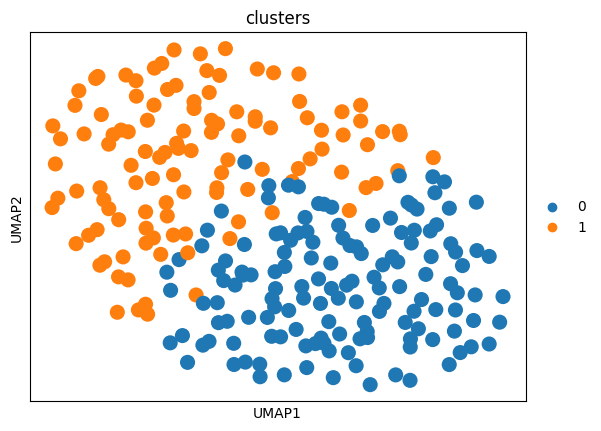

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


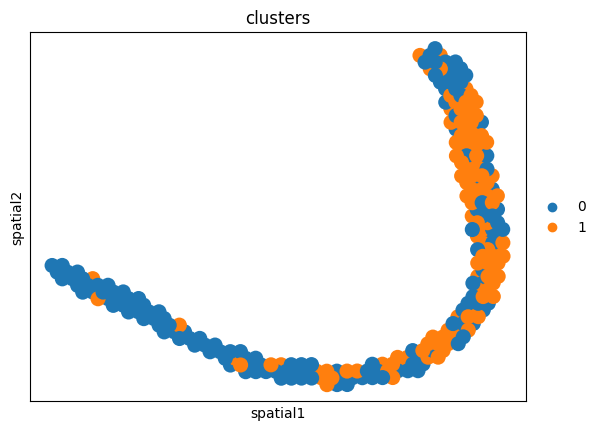

In [54]:
import scanpy as sc
sc.pp.normalize_total(adatal4, target_sum=1e4, inplace=True)
sc.pp.pca(adatal4 , n_comps=15)
sc.pp.neighbors(adatal4)
sc.tl.umap(adatal4)
sc.tl.leiden(adatal4 , key_added="clusters", resolution=0.5)
sc.pl.umap(adatal4, color="clusters")
sc.pl.embedding(adatal4, basis="spatial", color="clusters", cmap='plasma')

# run leiden clustering on interpolated data generated with stDiffusion

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


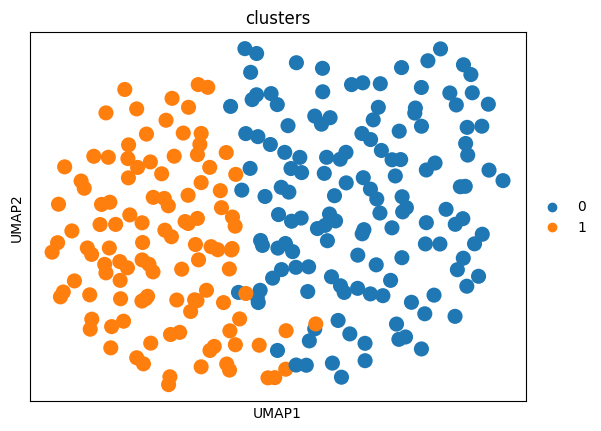

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


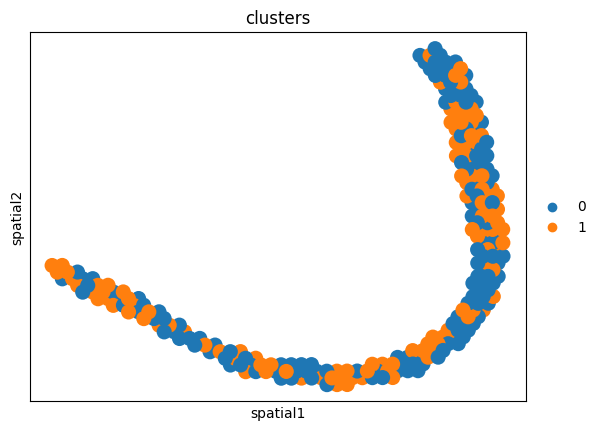

In [76]:
import scanpy as sc
sc.pp.normalize_total(layer4_interpolated_adata, target_sum=1e4, inplace=True)
sc.pp.pca(layer4_interpolated_adata , n_comps=15)
sc.pp.neighbors(layer4_interpolated_adata)
sc.tl.umap(layer4_interpolated_adata)
sc.tl.leiden(layer4_interpolated_adata , key_added="clusters", resolution=0.5)
sc.pl.umap(layer4_interpolated_adata, color="clusters")
sc.pl.embedding(layer4_interpolated_adata, basis="spatial", color="clusters", cmap='plasma')

# run leiden clustering on interpolated data generated with linear interpolation

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


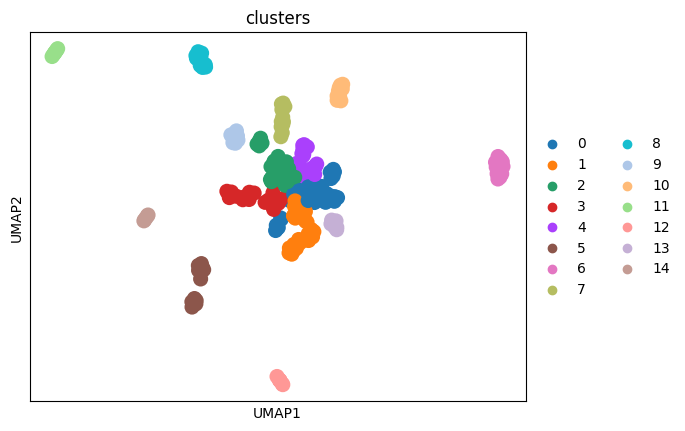

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


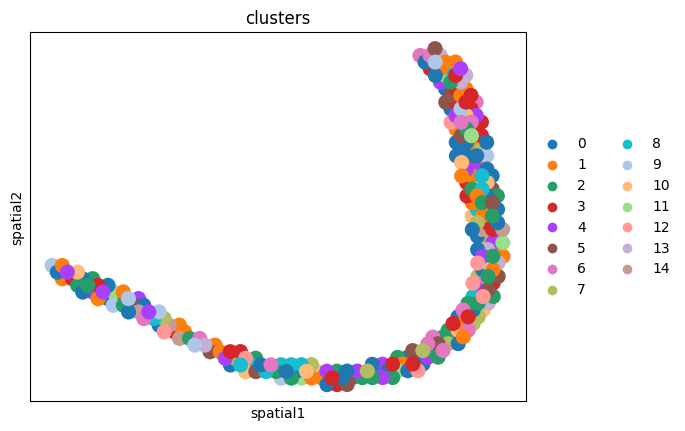

In [62]:
sc.pp.normalize_total(linear_layer4_interpolated_adata, target_sum=1e4, inplace=True)
sc.pp.pca(linear_layer4_interpolated_adata , n_comps=15)
sc.pp.neighbors(linear_layer4_interpolated_adata)
sc.tl.umap(linear_layer4_interpolated_adata)
sc.tl.leiden(linear_layer4_interpolated_adata , key_added="clusters", resolution=0.5)
sc.pl.umap(linear_layer4_interpolated_adata, color="clusters")
sc.pl.embedding(linear_layer4_interpolated_adata, basis="spatial", color="clusters", cmap='plasma')

# run neighborhood enrichment for reference DLPFC data

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


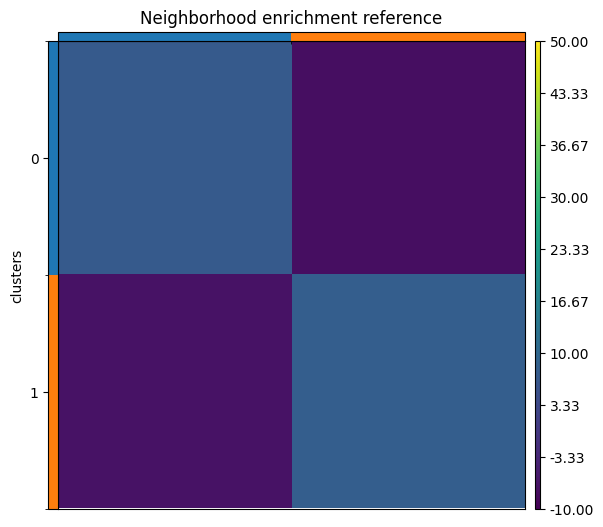

In [56]:
sq.gr.spatial_neighbors(adatal4, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(adatal4, cluster_key="clusters")
sq.pl.nhood_enrichment(
    adatal4,
    cluster_key="clusters",
    cmap="viridis",
    vmin=-10,
    vmax=50,
    figsize=(5, 5),
    title="Neighborhood enrichment reference"
)


# run neighborhood enrichment for interpolated DLPFC data with stDiffusion

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


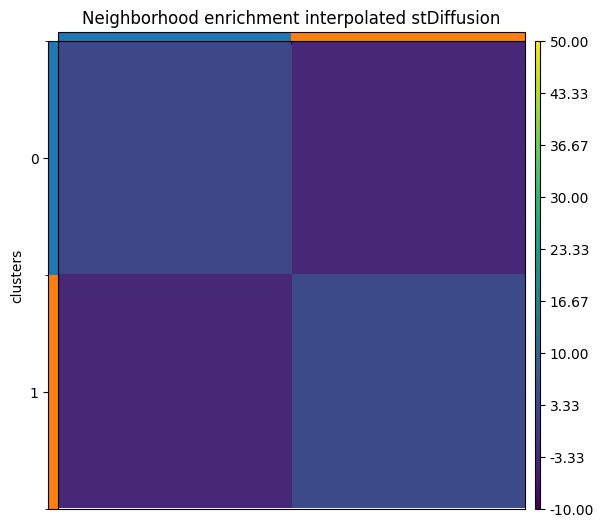

In [77]:
sq.gr.spatial_neighbors(layer4_interpolated_adata, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(layer4_interpolated_adata, cluster_key="clusters")
sq.pl.nhood_enrichment(
    layer4_interpolated_adata,
    cluster_key="clusters",
    cmap="viridis",
    vmin=-10,
    vmax=50,
    figsize=(5, 5),
    title="Neighborhood enrichment interpolated stDiffusion"
)


# run neighborhood enrichment for interpolated DLPFC data with linear interpolation

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


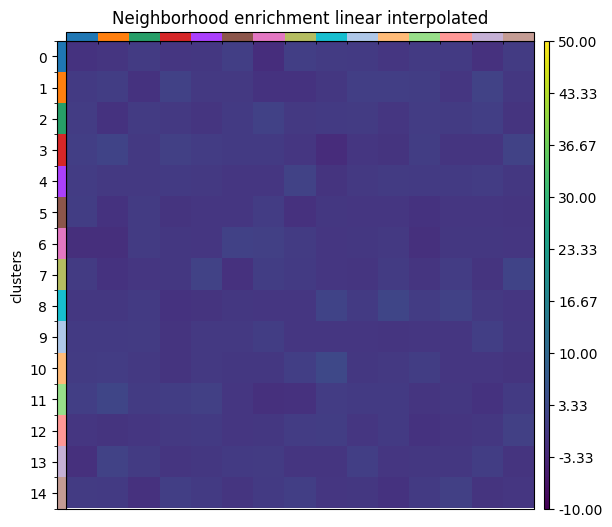

In [63]:
sq.gr.spatial_neighbors(linear_layer4_interpolated_adata, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(linear_layer4_interpolated_adata, cluster_key="clusters")
sq.pl.nhood_enrichment(
    linear_layer4_interpolated_adata,
    cluster_key="clusters",
    cmap="viridis",
    vmin=-10,
    vmax=50,
    figsize=(5, 5),
    title="Neighborhood enrichment linear interpolated"
)